In [637]:
# data wrangling
import numpy as np
import pandas as pd
import pytensor.tensor as pt

# bayesian statistics
import pymc as pm
from pymc_extras.distributions import DiscreteMarkovChain
import arviz as az

# statistics
import scipy.stats as stats

# plotting
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif' 
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8

## $$\text{Data Preparation}$$

In [638]:
sp500_url = "https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23ebf3fb&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1177&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=SP500&scale=left&cosd=2015-11-27&coed=2025-11-25&line_color=%230073e6&link_values=false&line_style=solid&mark_type=none&mw=3&lw=3&ost=-99999&oet=99999&mma=0&fml=a&fq=Daily%2C%20Close&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2025-11-26&revision_date=2025-11-26&nd=2015-11-27"

df = pd.read_csv(sp500_url).rename({"observation_date":"date"}, axis=1)
df['date'] = pd.to_datetime(df['date'])
df = df.set_index("date")

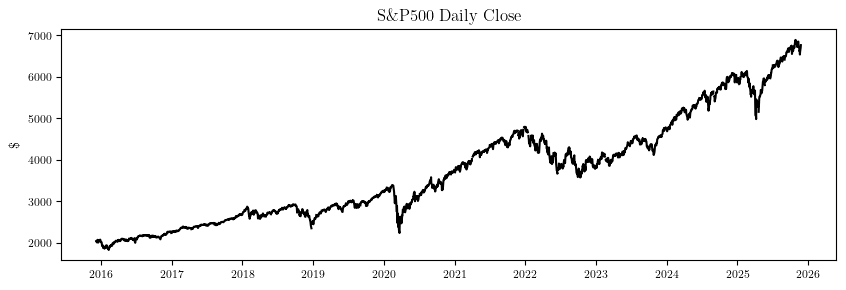

In [639]:
plt.figure(figsize=(10,3))
plt.plot(df, color="black")
plt.title("S\&P500 Daily Close")
plt.ylabel("\$")
plt.show()

In [640]:
# understanding NA values -- MAR, MNAR?
df[df.isna()["SP500"]].head(10)

,SP500
date,
2015-12-25,NaN
2016-01-01,NaN
2016-01-18,NaN
2016-02-15,NaN
2016-03-25,NaN
2016-05-30,NaN
2016-07-04,NaN
2016-09-05,NaN
2016-11-24,NaN


In [641]:
# NA values are all holidays, no imputation necessary -> safe to drop.
df = df.dropna()

In [642]:
diff_df = np.log(df).diff(1).dropna()

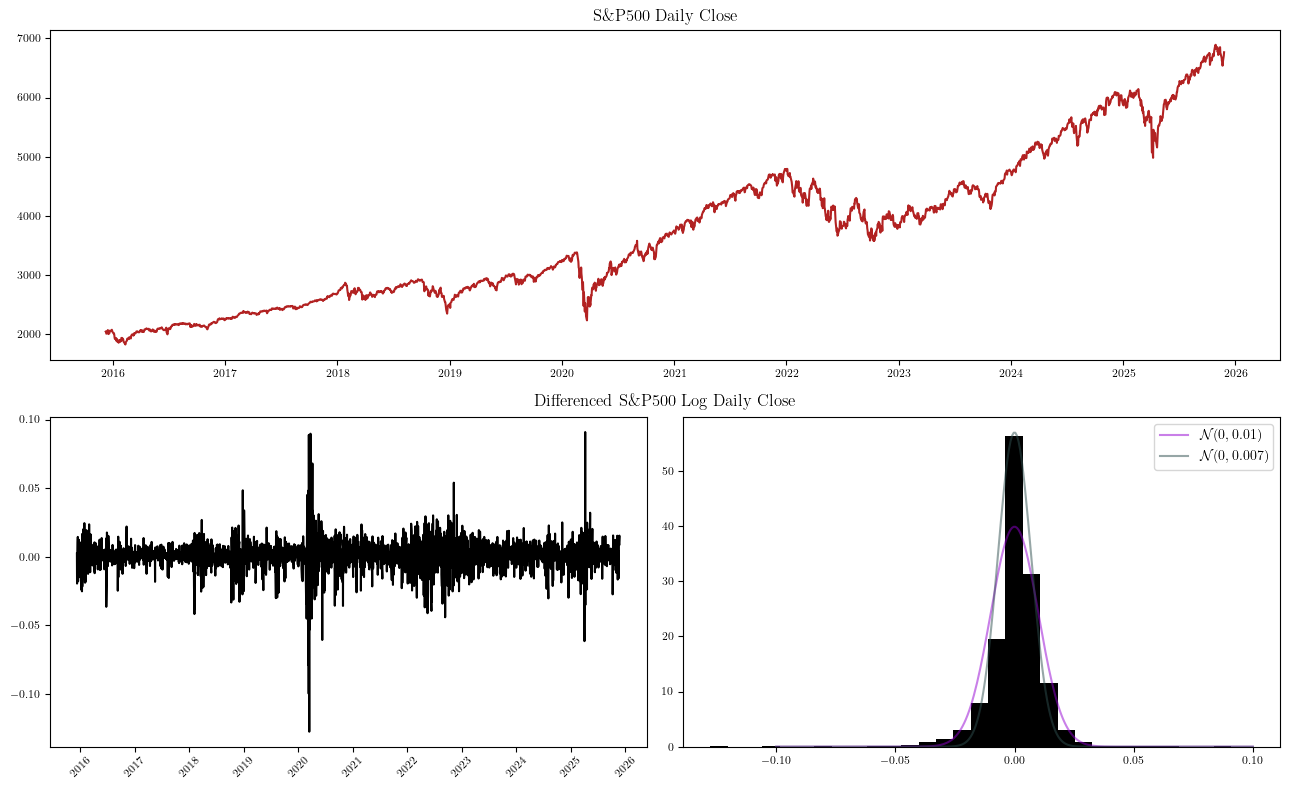

In [643]:
fig = plt.figure(figsize=(13, 8))
x_lin = np.linspace(-.10, .10, 300)

ax_raw = fig.add_subplot(2, 1, 1) 
ax_raw.plot(df, color="firebrick")
ax_raw.set_title("S\&P500 Daily Close")

ax_ts = fig.add_subplot(2, 2, 3) # Bottom-left
ax_hist = fig.add_subplot(2, 2, 4) # Bottom-right
# timeseries
ax_ts.plot(diff_df, color="black")
ax_ts.tick_params(axis='x', labelrotation=45)

# histogram
ax_hist.hist(diff_df, density=True, bins=30, color="black")
ax_hist.plot(x_lin, stats.norm(loc=0, scale=0.01).pdf(x_lin), label=r"$\mathcal{N}(0, 0.01)$", alpha=0.5, color="darkviolet")
ax_hist.plot(x_lin, stats.norm(loc=0, scale=0.007).pdf(x_lin), label=r"$\mathcal{N}(0, 0.007)$", alpha=0.5, color="darkslategray")
ax_hist.legend()

gs = fig.add_gridspec(2, 2)
ax_title = fig.add_subplot(gs[1, :]) 
ax_title.set_xticks([])
ax_title.set_yticks([])
ax_title.axis('off')

# Set the title using the new invisible axis. 
# We use y=1.05 to position it above the subplots.
ax_title.set_title("Differenced S\&P500 Log Daily Close", 
                   y=1.005)

#plt.tight_layout()
plt.tight_layout()
plt.savefig("../report/images/descr_ts_and_hist.png", dpi=600)
plt.show()

## $$\text{Prior Selection}$$

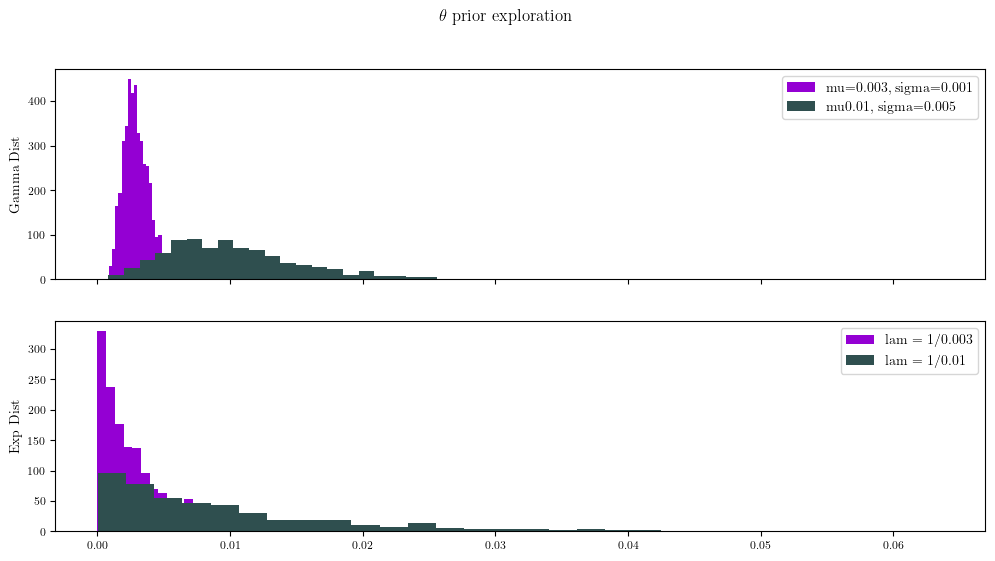

In [644]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12,6), sharex=True)
axs = axs.flatten()

# Gamma
axs[0].hist(pm.draw(pm.Gamma.dist(mu=0.003, sigma=0.001), draws=1000), density=True, bins=30, label="mu=0.003, sigma=0.001", color="darkviolet")
axs[0].hist(pm.draw(pm.Gamma.dist(mu=0.01, sigma=0.005), draws=1000), density=True, bins=30, label="mu0.01, sigma=0.005", color="darkslategray")
axs[0].set_ylabel("Gamma Dist")
axs[0].legend()

# Exponential
axs[1].hist(pm.draw(pm.Exponential.dist(lam = 1/0.003), draws=1000), label="lam = 1/0.003", density=True, bins=30, color="darkviolet")
axs[1].hist(pm.draw(pm.Exponential.dist(lam = 1/0.01), draws=1000), label="lam = 1/0.01", density=True, bins=30, color="darkslategray")
axs[1].set_ylabel("Exp Dist")
axs[1].legend()
fig.suptitle(r"$\theta$ prior exploration")

plt.show()


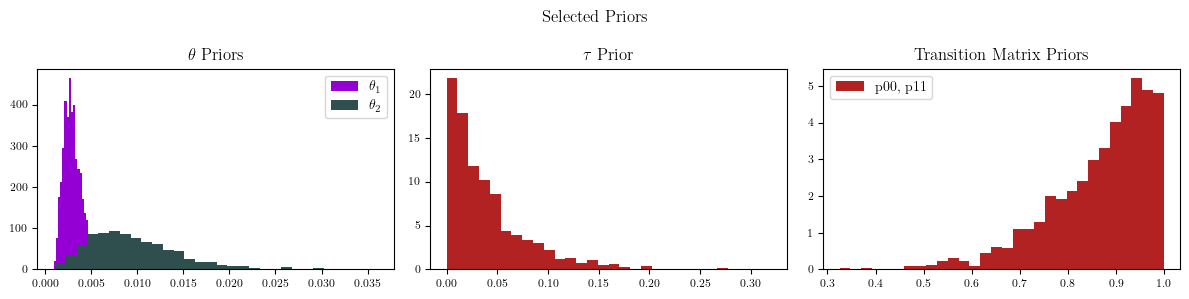

In [645]:
# Prior Selection
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
axs = axs.flatten()

# theta priors
axs[0].hist(pm.draw(pm.Gamma.dist(mu=0.003, sigma=0.001), draws=1000), density=True, bins=30, label=r"$\theta_1$", color="darkviolet")
axs[0].hist(pm.draw(pm.Gamma.dist(mu=0.01, sigma=0.005), draws=1000), density=True, bins=30, label=r"$\theta_2$", color="darkslategray")
axs[0].set_title(r"$\theta$ Priors")
axs[0].legend()

# tau prior
axs[1].hist(pm.draw(pm.Exponential.dist(25), draws=1000), density=True, bins=30, label="tau", color="firebrick")
axs[1].set_title(r"$\tau$ Prior")

# transition matrix priors
axs[2].hist(pm.draw(pm.Beta.dist(8, 1.2), draws=1000), density=True, bins=30, label="p00, p11", color="firebrick")
axs[2].set_title("Transition Matrix Priors")
axs[2].legend()

fig.suptitle("Selected Priors")
plt.tight_layout()
plt.show()

## $$\text{Model Development}$$

In [646]:
with pm.Model(coords={"time": diff_df.index.values}) as hmm_model:

    #priors
    tau = pm.Exponential("tau", 25)
    theta_1 = pm.Gamma("theta_1", mu=0.003, sigma=0.001)
    theta_2 = pm.Gamma("theta_2", mu=0.01, sigma=0.005)

    sigma = pm.Gamma("sigma", mu=pt.stack([theta_1, theta_2]), sigma=tau, shape=2)

    p00 = pm.Beta("p00", 8, 1.2)
    p11 = pm.Beta("p11", 8, 1.2)

    trans_mat = pt.stack([
        pt.stack([p00, 1 - p00]),
        pt.stack([1 - p11, p11])
    ])
    init = pm.Bernoulli.dist(p=0.5)

    Z = DiscreteMarkovChain("Z", P=trans_mat, init_dist=init, steps=len(diff_df)-1, dims="time")

    Y = pm.Normal("Y", mu=0, sigma = sigma[Z], observed=diff_df.values.flatten(), dims="time")

    idata = pm.sample(draws=4500, tune=6000, chains = 4, target_accept=0.95)

az.summary(idata, filter_vars = "like", var_names="~Z")

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [tau, theta_1, theta_2, sigma, p00, p11]
>DiscreteMarkovChainGibbsMetropolis: [Z]
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.

/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


Sampling 4 chains for 6_000 tune and 4_500 draw iterations (24_000 + 18_000 draws total) took 4164 seconds.
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,0.006,0.005,0.000,0.014,0.000,0.0,5123.0,3572.0,1.00
theta_1,0.004,0.001,0.002,0.006,0.000,0.0,11907.0,9708.0,1.00
theta_2,0.015,0.004,0.006,0.022,0.000,0.0,8168.0,7387.0,1.00
sigma[0],0.006,0.000,0.006,0.007,0.000,0.0,122.0,455.0,1.02
sigma[1],0.019,0.001,0.017,0.020,0.000,0.0,159.0,442.0,1.01
p00,0.982,0.004,0.974,0.990,0.000,0.0,420.0,1407.0,1.01
p11,0.959,0.010,0.940,0.976,0.001,0.0,273.0,1117.0,1.01


In [647]:
az.summary(idata, filter_vars = "like", var_names="~Z")[["ess_bulk", "ess_tail", "r_hat"]]


,ess_bulk,ess_tail,r_hat
tau,5123.0,3572.0,1.00
theta_1,11907.0,9708.0,1.00
theta_2,8168.0,7387.0,1.00
sigma[0],122.0,455.0,1.02
sigma[1],159.0,442.0,1.01
p00,420.0,1407.0,1.01
p11,273.0,1117.0,1.01


In [648]:
Z_summary = az.summary(idata, filter_vars = "like", var_names="Z")

Z_summary["ess_bulk"].min(), Z_summary["ess_tail"].min(), Z_summary["r_hat"].max()

/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/arviz/stats/diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-pack

(np.float64(68.0), np.float64(68.0), np.float64(1.05))

In [666]:
Z_summary["ess_bulk"].mean(), Z_summary["ess_tail"].mean(), Z_summary["r_hat"].mean()

(np.float64(7004.718163672655),
 np.float64(8773.864670658682),
 np.float64(1.0027738735014469))

## $$\text{Model Convergence Diagnostics}$$

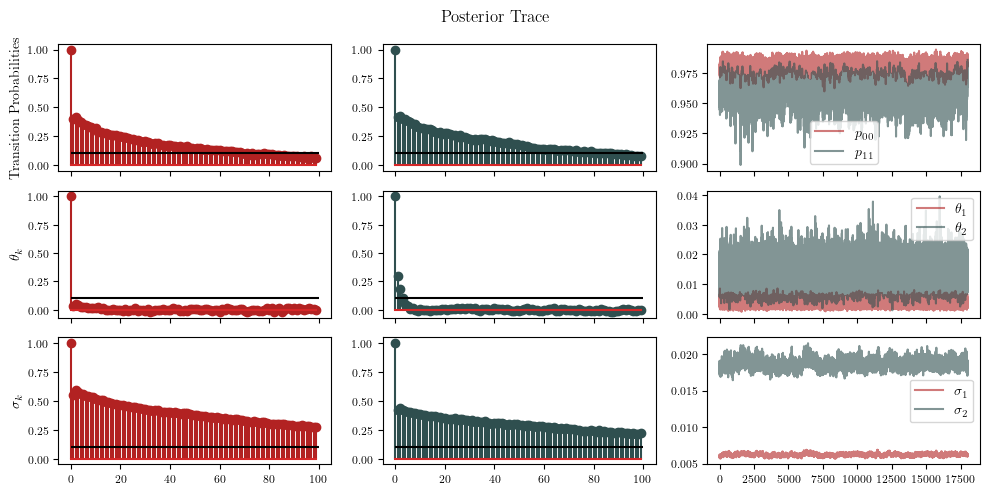

In [649]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(10,5), sharex="col")

# transition matrix
axs[0,0].set_ylabel("Transition Probabilities")
axs[0,0].stem(az.autocorr(idata.posterior.p00.stack(sample=("chain", "draw")).values)[:100], linefmt="firebrick")
axs[0,0].hlines(0.1, xmin=0, xmax=100, color="k")
axs[0,1].stem(az.autocorr(idata.posterior.p11.stack(sample=("chain", "draw")).values)[:100], linefmt="darkslategrey")
axs[0,1].hlines(0.1, xmin=0, xmax=100, color="k")
axs[0,2].plot(idata.posterior.p00.stack(sample=("chain", "draw")).values, label=r"$p_{00}$", color="firebrick", alpha=0.6)
axs[0,2].plot(idata.posterior.p11.stack(sample=("chain", "draw")).values, label=r"$p_{11}$", color="darkslategrey", alpha=0.6)
axs[0,2].legend()

# theta
axs[1,0].set_ylabel(r"$\theta_k$")
axs[1,0].stem(az.autocorr(idata.posterior.theta_1.stack(sample=("chain", "draw")).values)[:100], linefmt="firebrick")
axs[1,0].hlines(0.1, xmin=0, xmax=100, color="k")
axs[1,1].stem(az.autocorr(idata.posterior.theta_2.stack(sample=("chain", "draw")).values)[:100], linefmt="darkslategrey")
axs[1,1].hlines(0.1, xmin=0, xmax=100, color="k")
axs[1,2].plot(idata.posterior.theta_1.stack(sample=("chain", "draw")).values, label= r"$\theta_1$", color="firebrick", alpha=0.6)
axs[1,2].plot(idata.posterior.theta_2.stack(sample=("chain", "draw")).values, label= r"$\theta_2$", color="darkslategrey", alpha=0.6)
axs[1,2].legend()

# sigma
colors = ["firebrick", "darkslategrey"]
for i in range(2):
    axs[2,i].stem(az.autocorr(idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:])[:100], linefmt=colors[i])
    axs[2,i].hlines(0.1, xmin=0, xmax=100, color="k")
    axs[2,2].plot(idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:], label = fr"$\sigma_{i+1}$", color=colors[i], alpha=0.6)

axs[2,0].set_ylabel(r"$\sigma_k$")
axs[2,2].legend()


fig.suptitle("Posterior Trace")
plt.tight_layout()
plt.savefig("../report/images/posterior_traces.png", dpi=600)
plt.show()

## $$\text{Posterior Inspection}$$

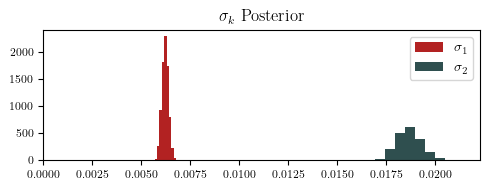

$\sigma_1$ Posterior Mean: 0.0062      95% Cred Int: [0.0059 0.0066]
$\sigma_2$ Posterior Mean: 0.0187      95% Cred Int: [0.0175 0.02  ]


In [660]:
# sigma posterior
plt.figure(figsize=(5, 2))
colors = ["firebrick", "darkslategrey"]
for i in range(2):
    plt.hist(idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:], label = fr"$\sigma_{i+1}$", density=True, color=colors[i])
plt.legend()
plt.xlim(0)
plt.title(r"$\sigma_k$ Posterior")
plt.tight_layout()

plt.savefig("../report/images/sigma_posterior.png", dpi=600)
plt.show()

for i in range(2):
    mean = idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:].mean()
    cred_int = np.quantile(idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:], [0.025, 0.975])
    print(f"$\sigma_{i+1}$ Posterior Mean: {mean :.4f}      95% Cred Int: {cred_int.round(4)}")

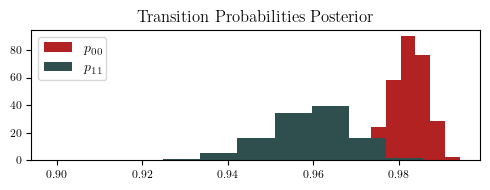

$p_00$ Posterior Mean: 0.9821      95% Cred Int: [0.9727 0.9895]
$p_11$ Posterior Mean: 0.9586      95% Cred Int: [0.9366 0.9753]


In [651]:
# state persistence posteriors

plt.figure(figsize=(5, 2))
plt.hist(idata.posterior.p00.stack(sample=("chain", "draw")).values, density=True, label=r"$p_{00}$", color="firebrick")
plt.hist(idata.posterior.p11.stack(sample=("chain", "draw")).values, density=True, label=r"$p_{11}$", color="darkslategrey")
plt.legend()
plt.title("Transition Probabilities Posterior")
plt.tight_layout()

plt.savefig("../report/images/state_persistence_posterior.png", dpi=600)
plt.show()

mean = idata.posterior.p00.stack(sample=("chain", "draw")).values.mean()
cred_int = np.quantile(idata.posterior.p00.stack(sample=("chain", "draw")).values, [0.025, 0.975])
print(f"$p_00$ Posterior Mean: {mean :.4f}      95% Cred Int: {cred_int.round(4)}")

mean = idata.posterior.p11.stack(sample=("chain", "draw")).values.mean()
cred_int = np.quantile(idata.posterior.p11.stack(sample=("chain", "draw")).values, [0.025, 0.975])
print(f"$p_11$ Posterior Mean: {mean :.4f}      95% Cred Int: {cred_int.round(4)}")

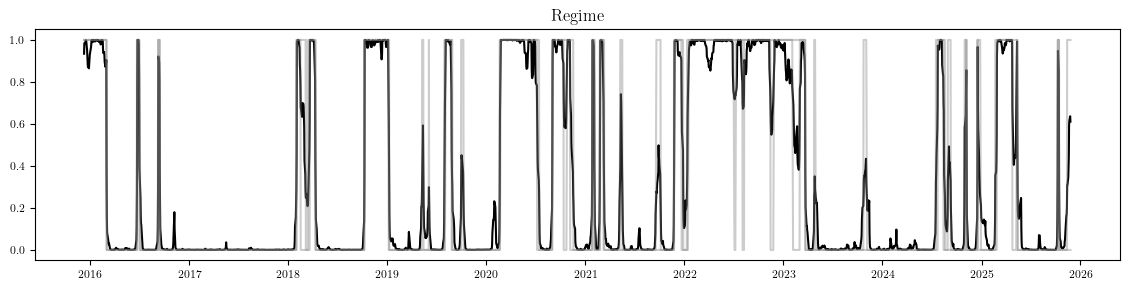

In [652]:
z_posterior = idata.posterior.Z.stack(sample=("chain", "draw")).values

plt.figure(figsize=(14,3))
plt.plot(diff_df.index.values, z_posterior.mean(axis=1), color="black")
plt.plot(diff_df.index.values, np.quantile(z_posterior, 0.25, axis=1), alpha=0.4, color="grey")
plt.plot(diff_df.index.values, np.quantile(z_posterior, 0.75, axis=1), alpha=0.4, color="grey")
plt.title("Regime")
plt.show()

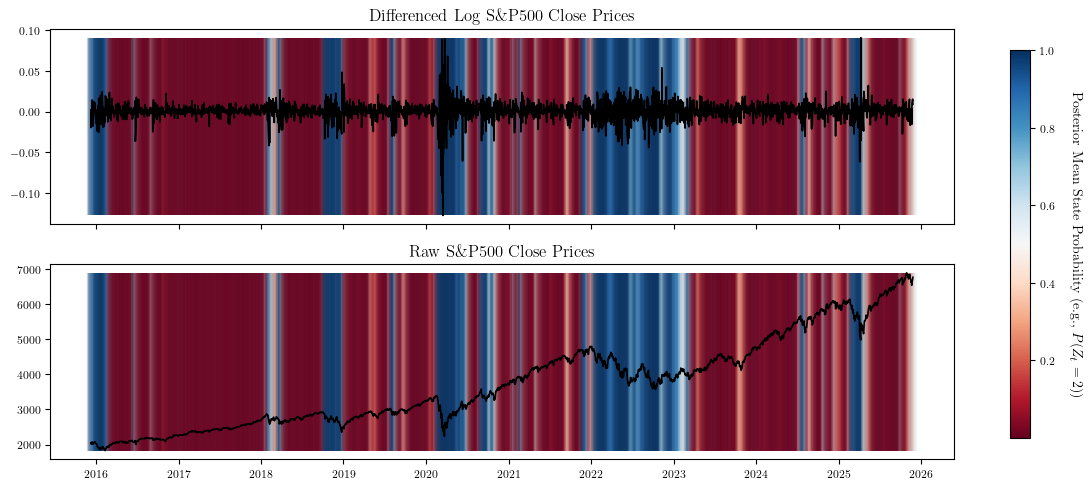

In [653]:
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates

# x: DatetimeIndex, y: series, cvals: numeric regime probs
cvals = idata.posterior.Z.stack(sample=("chain", "draw")).values.mean(axis=1)

# convert to float days
x_num = mdates.date2num(diff_df.index)

# build vertical segments in numeric coords
ymin, ymax = y.min(), y.max()
points = np.array([x_num, np.zeros_like(x_num)]).T  # placeholder
segments1 = [ [(x_num[i], diff_df.values.min()), (x_num[i], diff_df.values.max())] for i in range(len(x_num)) ]
segments2 = [ [(x_num[i], df.values.min()), (x_num[i], df.values.max())] for i in range(len(x_num)) ]

lc1 = LineCollection(segments1, cmap="RdBu", array=cvals,
                    linewidths=6, alpha=0.1, zorder=1)
lc2 = LineCollection(segments2, cmap="RdBu", array=cvals,
                    linewidths=6, alpha=0.1, zorder=1)

fig, axs = plt.subplots(nrows = 2, figsize=(12,5), sharex=True)
axs = axs.flatten()

axs[0].add_collection(lc1)
axs[1].add_collection(lc2)

# overlay the time series (use date plotting so axis shows dates)
axs[0].plot(diff_df.index, diff_df.values, color="black", linewidth=1.2, zorder=2)
axs[0].set_title("Differenced Log S\&P500 Close Prices")
axs[1].plot(df.index[1:], df.values[1:], color="black", linewidth=1.2, zorder=2)
axs[1].set_title("Raw S\&P500 Close Prices")
plt.tight_layout()

cbar = fig.colorbar(LineCollection(segments1, cmap="RdBu", array=cvals,
                    linewidths=6, alpha=1, zorder=1), ax=axs, orientation='vertical', shrink=0.9)
cbar.set_label("Posterior Mean State Probability (e.g., $P(Z_t=2)$)", rotation=270, labelpad=20)

plt.savefig("../report/images/ts_regime_posterior.png", dpi=600)
plt.show()


## $$\text{Posterior Predictive Check}$$

In [654]:
# posterior predictive
with hmm_model:
    post_pred_samples = pm.sample_posterior_predictive(idata)

Sampling: [Y]


/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/var/folders/q9/vssjztfs6gd47qy2w2t2f0t80000gn/T/ipykernel_21250/2284134576.py:6: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("../report/images/posterior_predictive.png", dpi=600)


[]

<Figure size 300x300 with 0 Axes>

/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


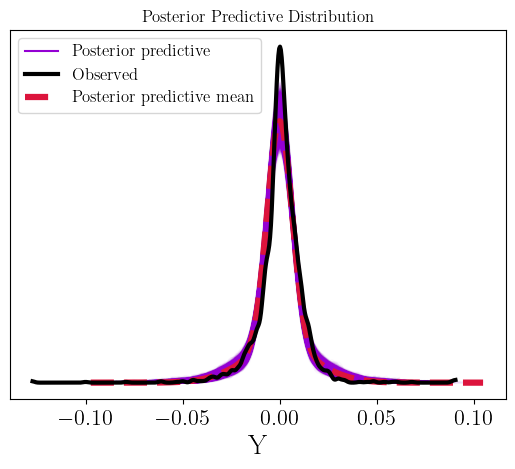

In [655]:
# posterior predictive check
plt.figure(figsize=(3, 3))
az.plot_ppc(post_pred_samples, alpha=0.03, colors=["darkviolet", "k", "crimson"], textsize=16)
plt.title("Posterior Predictive Distribution")

plt.savefig("../report/images/posterior_predictive.png", dpi=600)
plt.plot()

In [665]:
# our test statistic
def test(y, c):
    return sum( abs(y) > c) / len(y)

obs = post_pred_samples.observed_data.Y.values
const = np.quantile(obs, 0.9)

T_obs = test(obs, const)
rep_flat = az.extract(post_pred_samples, group="posterior_predictive", var_names="Y").T.values 
T_rep_values = np.empty(rep_flat.shape[0])

for i in range(rep_flat.shape[0]):
    T_rep_values[i] = test(rep_flat[i, :], const)

p_val = (T_rep_values > T_obs).mean()
print(f"Bayesian p-value (p_B): {p_val:.4f}")


Bayesian p-value (p_B): 0.8663


## $$\text{Prior Sensitivity Analysis}$$

In [657]:
# Prior Sensitivity Analysis
with pm.Model(coords={"time": diff_df.index.values}) as uninform_hmm_model:

    #priors
    tau = pm.HalfNormal("tau", sigma=6)
    theta_1 = pm.HalfNormal("theta_1", sigma=0.5)
    theta_2 = pm.HalfNormal("theta_2", sigma=1)

    sigma = pm.Gamma("sigma", mu=pt.stack([theta_1, theta_2]), sigma=tau, shape=2)

    p00 = pm.Beta("p00", 1, 1)
    p11 = pm.Beta("p11", 1, 1)

    trans_mat = pt.stack([
        pt.stack([p00, 1 - p00]),
        pt.stack([1 - p11, p11])
    ])
    init = pm.Bernoulli.dist(p=0.5)

    Z = DiscreteMarkovChain("Z", P=trans_mat, init_dist=init, steps=len(diff_df)-1, dims="time")

    Y = pm.Normal("Y", mu=0, sigma = sigma[Z], observed=diff_df.values.flatten(), dims="time")

    uninform_idata = pm.sample(draws=2000, tune=6000, chains = 3, target_accept=0.95)

az.summary(uninform_idata, filter_vars = "like", var_names="~Z")

Multiprocess sampling (3 chains in 3 jobs)
CompoundStep
>NUTS: [tau, theta_1, theta_2, sigma, p00, p11]
>DiscreteMarkovChainGibbsMetropolis: [Z]
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/rich/live.py:256: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


Sampling 3 chains for 6_000 tune and 2_000 draw iterations (18_000 + 6_000 draws total) took 2650 seconds.
/Users/pavlomysak/opt/anaconda3/envs/regime_switching/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
tau,2.144,1.548,0.111,4.847,0.026,0.033,2624.0,2079.0,1.00
theta_1,0.546,0.286,0.073,1.063,0.005,0.004,2990.0,2457.0,1.00
theta_2,0.802,0.477,0.074,1.665,0.008,0.006,2693.0,2622.0,1.00
sigma[0],0.006,0.000,0.006,0.007,0.000,0.000,15.0,123.0,1.14
sigma[1],0.019,0.001,0.017,0.020,0.000,0.000,22.0,242.0,1.09
p00,0.983,0.004,0.975,0.990,0.000,0.000,141.0,716.0,1.02
p11,0.960,0.009,0.944,0.978,0.001,0.000,178.0,787.0,1.01


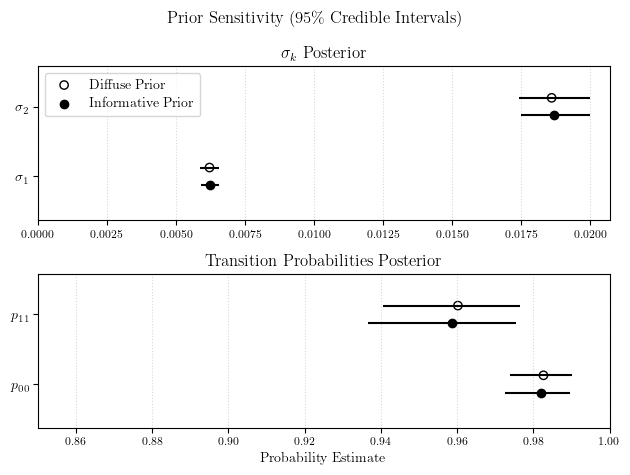

In [658]:
prior_shift = 0.25

fig, axs = plt.subplots(nrows=2, ncols=1)

for i in range(2):

    label_info = "Informative Prior" if i == 0 else None
    label_uninf = "Diffuse Prior" if i == 0 else None

    inf_dt = idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:]
    uninf_dt = uninform_idata.posterior.sigma.stack(sample=("chain", "draw")).values[i,:]
    
    # uninformative priors
    axs[0].scatter(x=uninf_dt.mean(), y=i+1+prior_shift, color="k", marker='o', facecolors='none', label=label_uninf)
    axs[0].hlines(y = i+1+prior_shift, xmin=np.quantile(uninf_dt, 0.025), xmax=np.quantile(uninf_dt, 0.975), color="k")

    # informative priors
    axs[0].scatter(x=inf_dt.mean(), y=i+1, color="k", marker='o', label=label_info)
    axs[0].hlines(y = i+1, xmin=np.quantile(inf_dt, 0.025), xmax=np.quantile(inf_dt, 0.975), color="k")


inf_p00 = idata.posterior.p00.stack(sample=("chain", "draw")).values
uninf_p00 = uninform_idata.posterior.p00.stack(sample=("chain", "draw")).values
inf_p11 = idata.posterior.p11.stack(sample=("chain", "draw")).values
uninf_p11 = uninform_idata.posterior.p11.stack(sample=("chain", "draw")).values

axs[1].scatter(x=inf_p00.mean(), y=1, color="k", marker='o')
axs[1].hlines(y = 1, xmin=np.quantile(inf_p00, 0.025), xmax=np.quantile(inf_p00, 0.975), color="k")
axs[1].scatter(x=uninf_p00.mean(), y=1+prior_shift, color="k", marker='o', facecolors='none')
axs[1].hlines(y = 1+prior_shift, xmin=np.quantile(uninf_p00, 0.025), xmax=np.quantile(uninf_p00, 0.975), color="k")

axs[1].scatter(x=inf_p11.mean(), y=2, color="k", marker='o')
axs[1].hlines(y = 2, xmin=np.quantile(inf_p11, 0.025), xmax=np.quantile(inf_p11, 0.975), color="k")
axs[1].scatter(x=uninf_p11.mean(), y=2+prior_shift, color="k", marker='o', facecolors='none')
axs[1].hlines(y = 2+prior_shift, xmin=np.quantile(uninf_p11, 0.025), xmax=np.quantile(uninf_p11, 0.975), color="k")

axs[0].set_title(r"$\sigma_k$ Posterior", fontsize=12)
axs[0].set_yticks([1.0 + 0.25/2, 2.0 + prior_shift/2])
axs[0].set_yticklabels([r"$\sigma_1$", r"$\sigma_2$"], fontsize=10)
axs[0].grid(axis='x', linestyle=':', alpha=0.5)
axs[0].set_ylim(0.5, 2.7)
axs[0].set_xlim(0)
axs[0].legend()

axs[1].set_title("Transition Probabilities Posterior", fontsize=12)
axs[1].set_xlabel("Probability Estimate", fontsize=10)
axs[1].set_yticks([1.0 + 0.25/2, 2.0 + prior_shift/2])
axs[1].set_yticklabels([r"$p_{00}$", r"$p_{11}$"], fontsize=10)
axs[1].grid(axis='x', linestyle=':', alpha=0.5)
axs[1].set_ylim(0.5, 2.7)
axs[1].set_xlim(0.85, 1)

fig.suptitle("Prior Sensitivity (95\% Credible Intervals)")
plt.tight_layout()

plt.savefig("../report/images/prior_sensitivity.png", dpi=600)
plt.show()